In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, timeit, torch, pystan as ps, arviz
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend
from tqdm import trange
from scipy.stats import gaussian_kde
from samplers import *

#### Generate data:

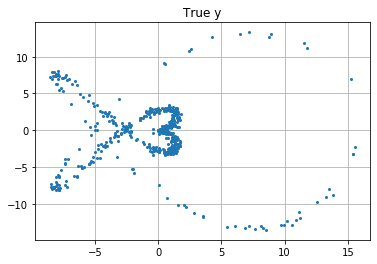

In [2]:
dd = np.load("model1.npy")
X, Y = dd.item()['X'], dd.item()['Y']
X.requires_grad = True
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y")
Nobs, n_in = np.shape(X)
n_out = np.shape(Y)[1]

### Testing GP prior for latent $X$:

#### Compile Stan function:

In [3]:
sm_GPprior = ps.StanModel(file="nn_GPprior.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ab34d44568499f597eea8aa87efb4011 NOW.


In [4]:
data_GPprior = dict(Nobs=Nobs, 
                    in_dim=n_in, 
                    out_dim=n_out, 
                    hidden_dim_1=50,
                    y=Y.detach().numpy())

#### Run sampling algorithm:

In [5]:
control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit_GPprior = sm_GPprior.sampling(data=data_GPprior, thin=1, n_jobs=4, chains=4, 
                                  init="random", iter=1_000, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit_GPprior);

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


2442.17 minutes to run
Inference for Stan model: anon_model_ab34d44568499f597eea8aa87efb4011.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
X[1,1]               0.42    1.59   2.25  -2.38  -1.66   0.25   2.47    3.7      2  15.99
X[2,1]              -0.61    2.92    4.2  -8.93  -2.77   0.36   2.48   4.76      2   6.81
X[3,1]               0.19    2.39   3.44   -7.3  -1.29   1.71   2.31   3.15      2   8.95
X[4,1]               0.77    1.39   1.97  -1.46  -0.97   0.24   2.53   3.86      2  16.16
X[5,1]               6.97    6.41   9.14  -0.65  -0.02   3.06  11.82  24.84      2   8.63
X[6,1]               -1.2    2.42   3.45  -8.03  -2.72   0.15   1.02   2.04      2   9.78
X[7,1]                1.8    1.67   2.38  -1.33  -0.14   1.41   3.54   6.07      2   8.85
X[8,1]              -1.87    1.11   1.57  -4.44  -3.11  -1.54  -0.51  

In [6]:
trace = fit_GPprior.extract()
(fit_GPprior.get_sampler_params())

[OrderedDict([('accept_stat__',
               array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                      1.00000000e+00, 1.00000000e+00, 9.99607366e-01, 9.99358473e-01,
                      9.85716214e-01, 9.95332296e-01, 4.72561461e-01, 8.09053135e-01,
                      9.74148191e-01, 9.44715710e-01, 1.86837553e-01, 9.96728492e-01,
                      9.80307557e-01, 9.97395234e-01, 9.88655387e-01, 9.93498743e-01,
                      6.38191141e-01, 8.33333715e-01, 9.97515972e-01, 9.70084216e-01,
                      9.72661112e-01, 3.69232403e-01, 9.95915843e-01, 9.89813650e-01,
                      9.76448802e-01, 2.84513825e-01, 9.87585609e-01, 9.96260295e-01,
                      8.78471544e-01, 9.97220625e-01, 9.71981071e-01, 9.07882068e-01,
                      7.58030948e-01, 9.67123941e-01, 8.31971545e-01, 4.65129971e-01,
                      9.97119921e-01, 9.96814091e-01, 9.31580194e-01, 7.22716340e-01,
                      

### Plot IACTs:

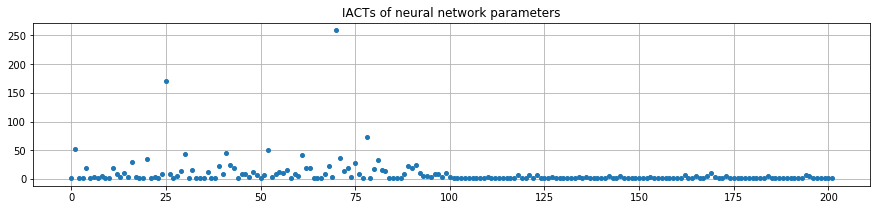

In [7]:
iact_nn = [gewer_estimate_IAT(trace['weights_1'][:,0,j]) 
          for j in range(np.shape(trace['weights_1'])[-1])] + \
         [gewer_estimate_IAT(trace['bias_1'][:,j]) 
         for j in range(np.shape(trace['bias_1'])[-1])] + \
[gewer_estimate_IAT(trace['weights_2'][:,i,j]) 
         for i in range(np.shape(trace['weights_2'])[-2]) 
         for j in range(np.shape(trace['weights_2'])[-1])] + \
[gewer_estimate_IAT(trace['bias_2'][:,j]) 
         for j in range(np.shape(trace['bias_2'])[-1])]
plt.figure(figsize=(15,3))
plt.plot(iact_nn, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of neural network parameters");

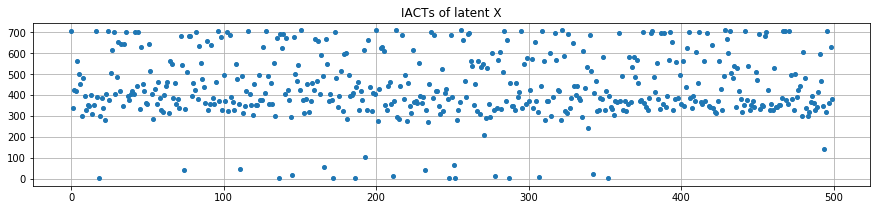

In [8]:
iact_x = [gewer_estimate_IAT(trace['X'][:,i,0]) for i in range(np.shape(trace['X'])[-2])]
plt.figure(figsize=(15,3))
plt.plot(iact_x, 'o', markersize=4)
plt.grid(True)
plt.title("IACTs of latent X");

#### Plot final:

In [32]:
n_HMC = np.shape(trace['X'])[0]
y_predicted = np.zeros((n_HMC, Nobs, n_out))
for i in range(Nobs) :
    y_predicted[i] = np.matmul(np.tanh(trace['X'][i]*trace['weights_1'][i] +
                                       trace['bias_1'][i]),trace['weights_2'][i]) + \
    trace['bias_2'][i] 

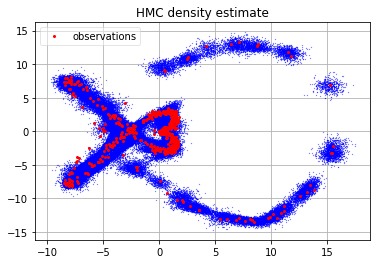

In [63]:
fig = plt.figure()
for i in range(Nobs) :
    plt.plot(y_predicted[i,:,0],y_predicted[i,:,1], 'bo', markersize=0.2)
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.grid(True)
plt.title("HMC density estimate");
plt.legend(ncol=2, loc='upper left', fancybox=True, framealpha=0.5)
fig.savefig('density_GPprior.png', dpi=1000, bbox_inches = 'tight')

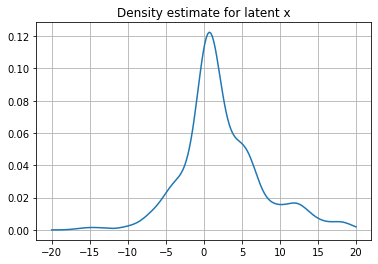

In [14]:
density = gaussian_kde(trace['X'][-1].flatten())
xs = np.linspace(-20,20,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.grid(True)
plt.title("Density estimate for latent x");

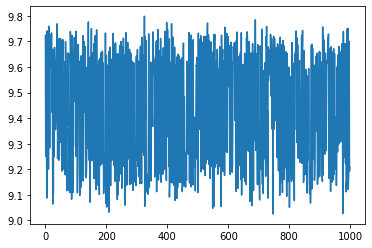

In [15]:
plt.plot(trace['X'][:,3])

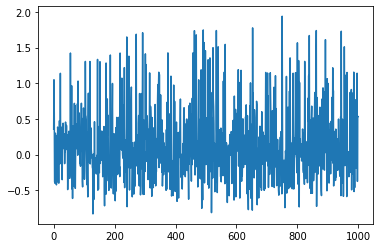

In [16]:
plt.plot(trace['weights_1'][:,0,20])

### Predictive distribution:

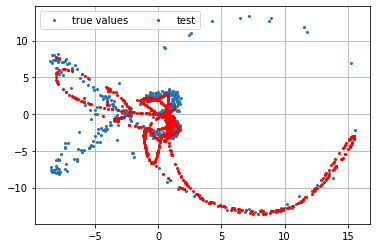

In [10]:
Ntest = 1_000
X_test = npr.randn(Ntest, n_in)
y_test = np.matmul(np.tanh(X_test*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 
plt.plot(list(Y[:,0]), list(Y[:,1]), 'o', markersize=2, label="true values")
plt.plot(y_test[:,0],y_test[:,1], 'ro', markersize=2, label="test")
plt.grid(True)
plt.legend(ncol=2)

In [11]:
K = np.zeros((Nobs,Nobs))
for i in trange(Nobs) :
    for j in range(Nobs) :
        K[i,j] = fit_GPprior['alpha'][-1]**2*np.exp(-1/(2*fit_GPprior['rho'][-1]**2)*np.linalg.norm(Y[i]-Y[j]))
        if j == i :
            K[i,j] += fit_GPprior['sigma2'][-1]

100%|██████████| 500/500 [07:24<00:00,  1.15it/s]


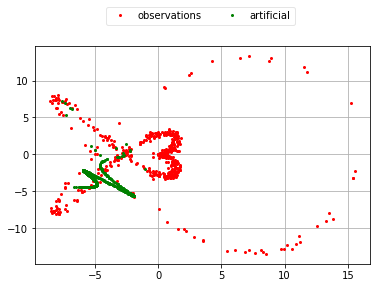

In [67]:
fig = plt.figure()
xsim = np.reshape(npr.multivariate_normal(np.zeros(Nobs),K),(Nobs,1))
y_sim = np.matmul(np.tanh(xsim*trace['weights_1'][-1] \
                           + trace['bias_1'][-1]),trace['weights_2'][-1]) \
         + trace['bias_2'][-1] 
plt.plot(list(Y[:,0]), list(Y[:,1]), 'ro', markersize=2, label="observations")
plt.plot(y_sim[:,0],y_sim[:,1], 'go', markersize=2, label="artificial")
plt.grid(True)
plt.grid(True)
plt.legend(ncol=2, loc=[0.21,1.1], fancybox=True, framealpha=0.5);
fig.savefig('predicted_GPprior.png', dpi=1000, bbox_inches = 'tight')